# Linear Regression

This notebook demonstrate a generic training pipeline to train a machine learning model. For this, we use a simple linear regression model to regress house prices.

![teaser](images/teaser.jpg)


## 1. Forward and Backward Pass

The aim of this exercse is to implement a linear model with forward and backward pass to regresses the housing prices based on the dataset HousingPrices. Have a look at the ```house-prices-data-exploration.ipynb``` from last week's exercise to get a nice overview of the dataset. The notebook also explains the dataloading and pre-processing steps that we will use in this exercise for dataloading.

$ $ A Linear Regression model is defined as follows:
Let $\mathbf{X} \in \mathbb{R}^{N\times D}$ denote our data with $N$ samples and $D$ feature dimensions. Our targets, the housing prices, are given by $\mathbf{y} \in \mathbb{R}^{N\times 1}$. We want to estimate them with a linear model that predicts the price at which a house was sold based on a set of features, i.e., a model of the form

$$ \hat{y_{i}}  = \mathbf{x}_i \cdot \mathbf{w} + b, $$ 

$ $ where $\mathbf{w}\in \mathbb{R}^{D \times 1}$ is the weight of our linear model, $b$ the bias, and the index $i$ denotes one sample. If we extend the our samples with a column of 1s $(\mathbf{X} \in \mathbb{R}^{N\times (D+1)})$, we can absorb the bias into the weight $\mathbf{w} \in \mathbb{R}^{(D+1) \times 1}$ (note the +1 in the feature dimension), such that we only have a matrix multiplication resulting in 

$$ \mathbf{y} = \mathbf{X} \mathbf{w} $$

$ $ over all $N$ samples.

Here you can see an example of a 1-D linear regression.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/1200px-Linear_regression.svg.png" width="800">

In [1]:
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader  import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Load your data

In the following, we apply preprocessing steps from ```house-prices-data-exploration.ipynb```. In machine learning, it is always important that any preprocessing step we apply on the training data is also applied on the validation and test data. 

The features are at very different scales and variances. Therfore, we normalize the features ranges with the minimum and maximum value of each numeric column. For filling in missing numeric values (if any), we need the mean value. These values we should pre-compute on the training set and feed them to the transform that is used on all dataset splits.

$ $ For means of visualization, we only consider number of features $D=1$. 

In [2]:
target_column = "SalePrice"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

Compute min, max and mean for each feature column for the transforms.

In [3]:
df = train_dataset.df
target_column = 'SalePrice'
# Select only 2 features to keep plus the target column.
selected_columns = ['GrLivArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn


Now, we perform the same transformation on the training, validation, and test data.

In [4]:
# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


$ $ We load the data into one matrix of shape $(N, D)$, similar for the targets.

In [5]:
# load training data into a matrix of shape (N, D), same for targets resulting in the shape (N, 1)
X_train = [train_dataset[i]['features'] for i in range((len(train_dataset)))]
X_train = np.stack(X_train, axis=0)
y_train = [train_dataset[i]['target'] for i in range((len(train_dataset)))]
y_train = np.stack(y_train, axis=0)
print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)

# load validation data
X_val = [val_dataset[i]['features'] for i in range((len(val_dataset)))]
X_val = np.stack(X_val, axis=0)
y_val = [val_dataset[i]['target'] for i in range((len(val_dataset)))]
y_val = np.stack(y_val, axis=0)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)

# load test data
X_test = [test_dataset[i]['features'] for i in range((len(test_dataset)))]
X_test = np.stack(X_test, axis=0)
y_test = [test_dataset[i]['target'] for i in range((len(test_dataset)))]
y_test = np.stack(y_test, axis=0)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape)



train data shape: (876, 1)
train targets shape: (876, 1)
val data shape: (292, 1)
val targets shape: (292, 1)
test data shape: (292, 1)
test targets shape: (292, 1)


In [6]:
a= np.random.randn(3,4)
np.concatenate((a, np.ones((3,1))),axis=1)

array([[ 1.76004575, -0.67766674, -1.12117761, -1.10527218,  1.        ],
       [-0.77080449, -0.15608725, -1.12352842,  1.11133061,  1.        ],
       [ 0.47326074, -0.62501395,  0.81641328,  1.08780601,  1.        ]])

### Set up a linear model

$ $ We define a linear model in ```exercise_code/networks/linear_model.py```. 
Your task is now to implement the forward pass in method ```forward()``` and the backward pass in ```backward()``` in the Network class ```LinearModel```. 

In [7]:
from exercise_code.networks.linear_model import LinearModel

model = LinearModel(num_features=1)

# choose weights for initialization
weights = np.array([[0.8, 0]]).transpose()
model.initialize_weights(weights)

# forward pass
y_out, _ = model(X_train)

We visualize the result of the forward pass in the following. Note that we choose the weights for the initialization of our model. As you can see, by choosing a good prior, you can already get good results.

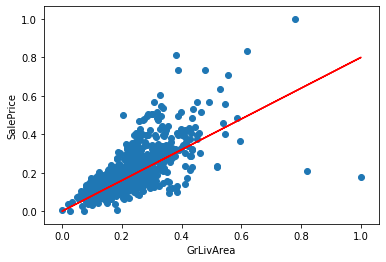

In [8]:
# plot the predictions
plt.scatter(X_train, y_train)
plt.plot(X_train, np.squeeze(y_out), color='r')
plt.xlabel('GrLivArea');
plt.ylabel('SalePrice');

$ $ Since we normalized our dataset, the predictions are still in the range $[0, 1]$. Let's scale them back to the original range with min, max and mean from above:

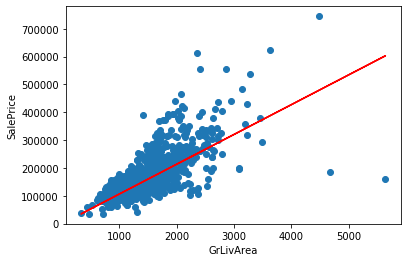

In [9]:
def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn

# compute predictions by resacling the predicted values
X_rescaled = rescale(X_train, key = "GrLivArea")
y_rescaled = rescale(y_out, key = "SalePrice")

# plot the predictions
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.plot(X_rescaled, y_rescaled, color='r')
plt.xlabel('GrLivArea');
plt.ylabel('SalePrice');

In the aforementioned visualisation we already initialised the weigths of model wiith a good guess. But what do we have to do, if we do not know the model weights yet. For linear regression we can solve the problem analytically. However, this is not possible for more complex models such as neural networks. Therefore, we have to compute a solution nummericially.



## 2. Gradient Descent

In order to train our model we will discuss the following steps in this exercise:

- Implement a **loss function** for your model
- **Compute the gradient** of your loss function
- **Check your implementation** with numerical gradient
- **Optimize** the loss function with **gradient descent**

### Loss Function


In order to apply and train you model you have to first define a loss or objective fucntion to which respect you want to optimize your model to. For the task of regression, we usually consider  $ L_{1}$, 
$$ L_{1} = |y - \hat y|,  $$
and mean squared error (MSE), 
MSE loss function is:
$$ MSE = (y - \hat y)^2,  $$
$ $ where $y$ is the output of your model, and $\hat y$ is the ground truth of the data.

Now it is time to implement your loss function in `exercise_code/networks/loss.py` and write the forward and backward pass of $ L_{1}$ and MSE as `forward` and `backward` function. The backward pass of the loss is needed to later optimize your weights of the model.



Once you have implemented you loss function you can import your functions.

In [10]:
from exercise_code.networks.loss import L1, MSE

l1_loss = L1()
mse_loss = MSE()

In [37]:
a = np.random.randn(3,4)
print(a)
a = np.where(a>0, 1, -1)
print(a)
b = np.random.randn(3,4)
a[np.where(b>0)]=0
print(a)

[[-3.67895961 -0.58260647 -0.50779413  0.82000165]
 [ 0.06792184  1.27298958  0.07560102 -0.04215595]
 [-1.77289625 -0.97447972 -0.93729936  1.03061443]]
[[-1 -1 -1  1]
 [ 1  1  1 -1]
 [-1 -1 -1  1]]
[[ 0  0 -1  0]
 [ 0  1  1 -1]
 [-1 -1 -1  0]]


### Forward and Backward Check

Once you have finished implementation of L1 and MSE loss class, you can run the following code to check whether your forward result and backward gradient are correct. You should expect your relative error to be lower than 1e-8. (Note that gradients at 0 of $ L_{1}$ loss is also 0! )

Here we will use a numeric gradient check to debug the backward pass:

$$ \frac {df(x)}{dx} = \frac{f(x+h) - f(x-h)}{2h} $$

where $h$ is a very small number, in practice approximately 1e-5 or so.


In [11]:
from exercise_code.tests.loss_tests import *
print (L1Test(l1_loss)())
print (MSETest(mse_loss)())


L1ForwardTest passed.
L1BackwardTestZero passed.
L1BackwardTestNormal passed.
Congratulations you have passed all the unit tests!!! Tests passed: 3/3
(0, 3)
MSEForwardTest passed.
MSEBackwardTest passed.
Congratulations you have passed all the unit tests!!! Tests passed: 2/2
(0, 2)


When the tests were successful, you can continue with implementing gradient descent and your optimizer.



### Optimizer and Gradient Descent

Previously, we have successfully dealt with the loss function, which is a mathematical tool for predicting the prediction effect.

During the training process, we will adjust the parameters (weights) of the model to try to minimize the loss function and try to optimizer the predictions of our model.

This is where the optimizer comes in. They update the model with respect to the output of the loss function, thereby linking the loss function and model parameters together. In short, the optimizer shapes and models the most accurate form by updating weights. The loss function is a guide to the terrain and can tell the optimizer when to move in the right or wrong direction.

Any discussion about optimizers needs to begin with the most popular one, and it is called Gradient Descent. This algorithm is used across all types of Machine Learning (and other math problems) to optimize. It is fast, robust, and flexible. Here is how it works:

1. Calculate the gradient in each individual weight would do to the loss function;
2. Ubdate each weight based on its gradient;
3. Iterativily doing step 1 and step 2 till convergence.

Gradient descent follows the following mathematical form:

$$ W = W - \alpha \frac {dL}{dW}, $$
$ $ where $W$ is weight of your model, $\alpha$ is the learning rate you need to set before training (we will discuss that more in the comming lectures), $ \frac {dL}{dW}$ is the gradients of your loss function with respect to the weight.

### Implement a Naive Optimizer using Gradient Descent 

Here we will use gradient descent method to update our loss function to see how it changes when updating our weights in the model. Open the file `exercise_code/networks/optimizer.py` and implement the gradients descent step into the `step()` function.


(876, 1)


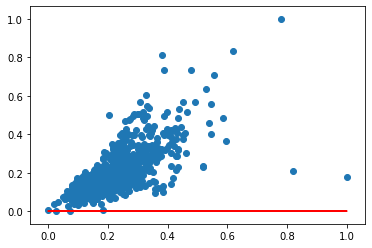

In [12]:
from exercise_code.networks.optimizer import *

X_train = X_train
X_val = X_val
# Implement Linear Model and initialize the weights.
model = LinearModel(num_features=1)
model.initialize_weights()

print(np.shape(X_train))
# forward pass
y_out, _ = model(X_train)
# plot the prediction
plt.scatter(X_train, y_train)
plt.plot(X_train, y_out, color='r')
plt.show()

As you can see, the prediciton of the model are really bad when we randomly initialise the weights. Let's see how this changes, when we apply gradient descent to the weights.

Epoch  0 --- Average Loss:  0.055604475567228764
Epoch  1 --- Average Loss:  0.012454119485249663
Epoch  2 --- Average Loss:  0.012236175655626229
Epoch  3 --- Average Loss:  0.012129811342020633
Epoch  4 --- Average Loss:  0.012025789100886692
Epoch  5 --- Average Loss:  0.011923790357273983
Epoch  6 --- Average Loss:  0.011823775066328169
Epoch  7 --- Average Loss:  0.011725704656377576
Epoch  8 --- Average Loss:  0.011629541307579917
Epoch  9 --- Average Loss:  0.011535247935535897
Epoch  10 --- Average Loss:  0.011442788176983387
Epoch  11 --- Average Loss:  0.01135212637577431
Epoch  12 --- Average Loss:  0.011263227569124219
Epoch  13 --- Average Loss:  0.011176057474129244
Epoch  14 --- Average Loss:  0.01109058247454526
Epoch  15 --- Average Loss:  0.011006769607824136
Epoch  16 --- Average Loss:  0.010924586552402056
Epoch  17 --- Average Loss:  0.01084400161523504
Epoch  18 --- Average Loss:  0.010764983719576876
Epoch  19 --- Average Loss:  0.010687502392994654
Epoch  20 ---

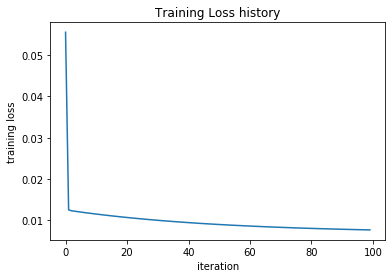

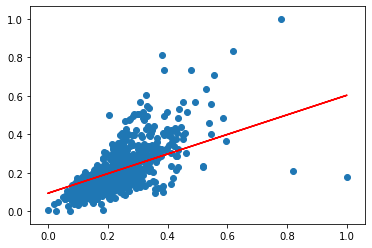

In [13]:
# Hyperparameter Setting, we will specify the loss function we use, and implement
# the optimizer we finished in the last step.
loss_func = MSE() 
learning_rate = 5e-1
loss_history = []
opt = Optimizer(model,learning_rate)
steps = 100
# Full batch Gradient Descent
for i in range(steps):
    
    # Enable your model to store the gradient.
    model.train()
    
    # Compute the output and gradients with repect to weight of your model for the input dataset.
    model_forward,model_backward = model(X_train)
    
    # Compute the loss and gradients with repect to output of the model.
    loss, loss_grad = loss_func(model_forward, y_train)
    
    # Use back prop method to get the gradients of loss with respect to the weights.
    grad = loss_grad * model_backward
    
    #Compute the average gradient over your batch
    grad = np.mean(grad, 0, keepdims = True)

    # After obtaining the gradients of loss with respect to the weights, we can use optimizer to
    # do gradient descent step.
    opt.step(grad.T)
    
    # Average over the loss of the entire dataset and store it.
    average_loss = np.mean(loss)
    loss_history.append(average_loss)
    print("Epoch ",i,"--- Average Loss: ", average_loss)

# Plot the loss history to see how it goes after several steps of 
# gradient descent.
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


# forward pass
y_out, _ = model(X_train)
# plot the prediction
plt.scatter(X_train, y_train)
plt.plot(X_train, y_out, color='r')
plt.show()

We can see that our loss decreases and the linear model improves to ecplain the variables.

# 3. Solver

Now that you've learned how to build your own neural regressors and classifiers, let's put everything together.
This part of the exercise will require you to complete the missing code in the 'Solver' class, and use that to train your models end to end.

The purpose of a solver is to mainly to provide an abstraction for all the gritty details behind training your parameters, such as logging your progress, optimizing your model, and handling your data.

In order to explore the full generality of the solver, we will address two common tasks in machine learning of machine learning, namely classification and regression.

### Implement a Solver

Open the file `exercise_code/solver.py` and finalize the `_step()`function. 

Note that we will initialize our solver with given training and validation set and perform loss update by calling `_step()`, here you may use the `backward()` or `__call()__` function in your loss and model to calculate the gradients of the loss with respect to the weight, and finally perform gradient descent with the help of `step()` function in your optimizer.

In [23]:
df.columns
df['OverallQual'].unique()

array([ 6,  5,  7,  8, 10,  4,  9,  3,  2,  1])

In [56]:
df = train_dataset.df
target_column = 'SalePrice'
# Select only 2 features to keep plus the target column.
# selected_columns = ['GrLivArea',  target_column]
selected_columns = ['GrLivArea', 'GarageArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))


# load training data into a matrix of shape (N, D), same for targets resulting in the shape (N, 1)
X_train = [train_dataset[i]['features'] for i in range((len(train_dataset)))]
X_train = np.stack(X_train, axis=0)
y_train = [train_dataset[i]['target'] for i in range((len(train_dataset)))]
y_train = np.stack(y_train, axis=0)
print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)

# load validation data
X_val = [val_dataset[i]['features'] for i in range((len(val_dataset)))]
X_val = np.stack(X_val, axis=0)
y_val = [val_dataset[i]['target'] for i in range((len(val_dataset)))]
y_val = np.stack(y_val, axis=0)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print(X_val[:,0].shape)

# load test data
X_test = [test_dataset[i]['features'] for i in range((len(test_dataset)))]
X_test = np.stack(X_test, axis=0)
y_test = [test_dataset[i]['target'] for i in range((len(test_dataset)))]
y_test = np.stack(y_test, axis=0)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape)


Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292
train data shape: (876, 2)
train targets shape: (876, 1)
val data shape: (292, 2)
val targets shape: (292, 1)
(292,)
test data shape: (292, 2)
test targets shape: (292, 1)


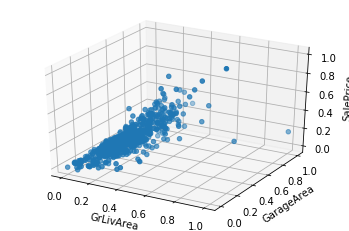

In [59]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:,0],X_train[:,1],y_train)

ax.set_xlabel('GrLivArea')
ax.set_ylabel('GarageArea')
ax.set_zlabel('SalePrice')

plt.show()


In [54]:
def plotdata(x, y, y_out, x_dim):
    x = x[:, x_dim]
    plt.scatter(x, y, label = "Ground Truth")
    inds = x.argsort(0).flatten()
    plt.plot(x[inds], y_out[inds], color='r', label = "Prediction")
    plt.legend()
    plt.show()

    

L1 loss on test set BEFORE training: 152,853
MSE loss on test set BEFORE training: 29,900,722,476
(Epoch 0 / 25000) train loss: 0.055728; val_loss: 0.059081
(Epoch 1000 / 25000) train loss: 0.011267; val_loss: 0.011314
(Epoch 2000 / 25000) train loss: 0.010468; val_loss: 0.010155
(Epoch 3000 / 25000) train loss: 0.010104; val_loss: 0.009733
(Epoch 4000 / 25000) train loss: 0.009774; val_loss: 0.009373
(Epoch 5000 / 25000) train loss: 0.009471; val_loss: 0.009045
(Epoch 6000 / 25000) train loss: 0.009193; val_loss: 0.008743
(Epoch 7000 / 25000) train loss: 0.008937; val_loss: 0.008464
(Epoch 8000 / 25000) train loss: 0.008701; val_loss: 0.008207
(Epoch 9000 / 25000) train loss: 0.008485; val_loss: 0.007970
(Epoch 10000 / 25000) train loss: 0.008285; val_loss: 0.007751
(Epoch 11000 / 25000) train loss: 0.008101; val_loss: 0.007549
(Epoch 12000 / 25000) train loss: 0.007932; val_loss: 0.007362
(Epoch 13000 / 25000) train loss: 0.007775; val_loss: 0.007189
(Epoch 14000 / 25000) train loss:

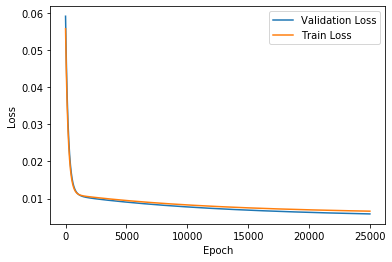

L1 loss on test set AFTER training: 32,502
MSE loss on test set AFTER training: 2,229,845,584


In [60]:

from exercise_code import solver

# Select the number of features, you want your task to train on.
# Feel free to play with the sizes.
num_features = X_train.shape[1]

# Use a simple linear model to perform linear regression
# on real-valued labels.
model = LinearModel(num_features=num_features)
model.initialize_weights()

# Build the actual dataset.
# Notice how we use an 80-20 train validation split.
# You're welcome to experiment with other splits
X_val = X_val
y_out, _ = model(X_val)

data = {'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val}

# We are going to use the L2 loss for this task, but L1 
# is also an appropriate loss function for this task.
l1_loss = L1()
mse_loss = MSE()


learning_rate = 1e-3
epochs = 25000

print("L1 loss on test set BEFORE training: {:,.0f}".format(l1_loss(rescale(y_out), rescale(y_val))[0].mean() ))
print("MSE loss on test set BEFORE training: {:,.0f}".format(mse_loss(rescale(y_out), rescale(y_val))[0].mean() ))

# if np.shape(X_test)[1]==1:
#     plt.scatter(X_val, y_val, label = "Ground Truth")
#     inds = X_val.argsort(0).flatten()
#     plt.plot(X_val[inds], y_out[inds], color='r', label = "Prediction")
#     plt.legend()
#     plt.show()
# plotdata(X_val, y_val, y_out, 0)
    
# Setup for the actual solver that's going to do the job of training
# the model on the given data. set 'verbose=True' to see real time 
# progress of the training.
solver = solver.Solver(model, data, mse_loss,
                       learning_rate, verbose=True, print_every= 1000)

# Train the model, and look at the results.
solver.train(epochs)
plt.plot(solver.val_loss_history, label = "Validation Loss")
plt.plot(solver.train_loss_history, label = "Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend() 
plt.show() 


# Test final performance
y_out, _ = model(X_test)


print("L1 loss on test set AFTER training: {:,.0f}".format(l1_loss(rescale(y_out), rescale(y_test))[0].mean() ))
print("MSE loss on test set AFTER training: {:,.0f}".format(mse_loss(rescale(y_out), rescale(y_test))[0].mean() ))

# if np.shape(X_test)[1]==1:
#     plt.scatter(X_test, y_test, label = "Ground Truth")
#     inds = X_test.argsort(0).flatten()
#     plt.plot(X_test[inds], y_out[inds], color='r', label = "Prediction")
#     plt.legend()
#     plt.show()
# plotdata(X_test, y_test, y_out, 0)

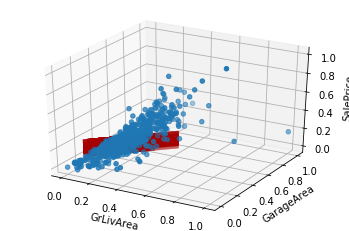

In [64]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train[:,0],X_train[:,1],y_train)

ax.set_xlabel('GrLivArea')
ax.set_ylabel('GarageArea')
ax.set_zlabel('SalePrice')



plt3d = fig.gca(projection='3d')
plt3d.plot_surface(X_test[:,0], X_test[:,0], y_out, alpha=0.2,color = 'r')


You can now play around with the different loss functions and use more than one feature to do the regression. Does the result improve? Note that if you want to add more features you need to build your own testing set with correspoing dimensions of the features, since here our testing set has only one feature.

Once this notebook is running and you have understood everything what is in there you can go to next notebook `2_logistic_regression.ipynb`.